# Asset replacement model

**Randall Romero Aguilar, PhD**

This demo is based on the original Matlab demo accompanying the  <a href="https://mitpress.mit.edu/books/applied-computational-economics-and-finance">Computational Economics and Finance</a> 2001 textbook by Mario Miranda and Paul Fackler.

Original (Matlab) CompEcon file: **demddp02.m**

Running this file requires the Python version of CompEcon. This can be installed with pip by running

    !pip install compecon --upgrade

<i>Last updated: 2021-Oct-01</i>
<hr>

## About

At the beginning of each year, a manufacturer must decide whether to continue to operate an aging physical asset or replace it with a new one. An asset that is $a$ years old yields a profit contribution $p(a)$ up to $n$ years, at which point the asset becomes unsafe and must be
replaced by law. The cost of a new asset is $c$. What replacement policy maximizes profits?

This is an infinite horizon, deterministic model with time $t$ measured in years.

## Initial tasks

In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from compecon import DDPmodel

## Model Parameters

Assume a maximum asset age of 5 years, asset replacement cost $c = 75$, and annual discount factor $\delta = 0.9$.

In [2]:
maxage  = 5
repcost = 75
delta   = 0.9

### State Space

The state variable $a \in \{1, 2, 3, \dots, n\}$ is the age of the asset in years.

In [3]:
S = np.arange(1, 1 + maxage)  # machine age
n = S.size                    # number of states

### Action Space

The action variable $x \in \{\text{keep, replace}\}$ is the hold-replacement decision. 

In [4]:
X = np.array(['keep', 'replace'])     # list of actions
m = len(X)                  # number of actions

### Reward Function

The reward function is
\begin{equation}
f(a, x) = \begin{cases} p(a), &x = \text{keep} \\
    p(0) - c, &x = \text{replace}
\end{cases}
\end{equation}

Assuming a profit contribution $p(a) = 50 − 2.5a − 2.5a^2$ that is a function of the asset age $a$ in years:

In [5]:
f = np.zeros((m, n))
f[0] = 50 - 2.5 * S - 2.5 * S ** 2
f[1] = 50 - repcost
f[0, -1] = -np.inf

### State Transition Function

The state transition function is
\begin{equation}
g(a, x) = \begin{cases} a + 1, &x = \text{keep} \\
    1, &x = \text{replace}
\end{cases}
\end{equation}

In [6]:
g = np.zeros_like(f)
g[0] = np.arange(1, n + 1)
g[0, -1] = n - 1  # adjust last state so it doesn't go out of bounds

## Model Structure

The value of an asset of age a satisfies the Bellman equation
\begin{equation}
V(a) = \max\{p(a) + \delta V(a + 1),\quad p(0) − c + \delta V(1)\}
\end{equation}

where we set $p(n) = -\infty$ to enforce replacement of an asset of age $n$. The Bellman equation asserts that if the manufacturer keeps an asset of age $a$, he earns $p(a)$ over the coming year and begins the subsequent year with an asset that is one year older and worth $V(a+1)$; if he replaces the asset, however, he starts the year with a new asset, earns $p(0)−c$ over the year, and begins the subsequent year with an asset that is one year old and worth $V(1)$. Actually, our language is a little loose here. The value $V(a)$ measures not only the current and future net earnings of an asset of age $a$, but also the net earnings of all future assets that replace it.

To solve and simulate this model, use the CompEcon class ```DDPmodel```. 

In [7]:
model = DDPmodel(f, g, delta)
model.solve()

A deterministic discrete state, discrete action, dynamic model.
There are 2 possible actions over 5 possible states

In [8]:
solution = pd.DataFrame({
    'Age of Machine': S,
    'Action': X[model.policy], 
    'Value': model.value}).set_index('Age of Machine')

solution['Action'] = solution['Action'].astype('category')

## Analysis

### Plot Optimal Value
This Figure gives the value of the firm at
the beginning of the period as a function of the asset’s age.

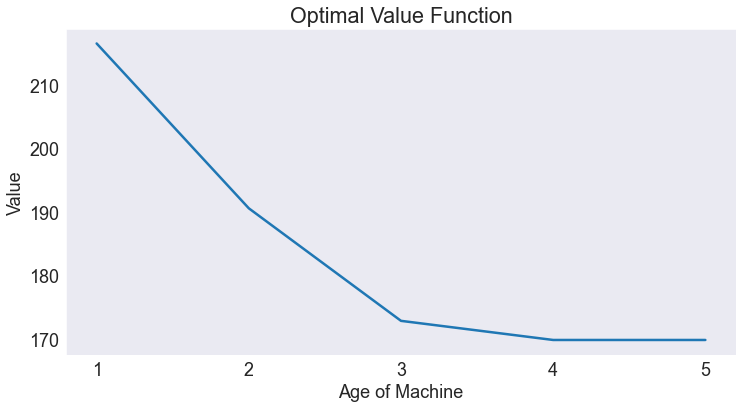

In [9]:
ax = solution['Value'].plot();
ax.set(title='Optimal Value Function', ylabel='Value', xticks=S);

### Plot Optimal Policy
This Figure gives the optimal action as a function of the asset’s age.

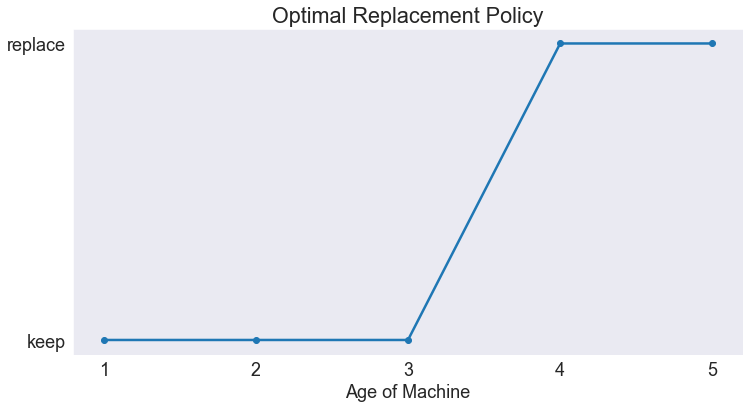

In [10]:
ax = solution['Action'].cat.codes.plot(marker='o')
ax.set(title='Optimal Replacement Policy', yticks=[0, 1], yticklabels=X, xticks=S);

### Simulate Model
The path was computed by performing a deterministic simulation of 12 years in duration using the ```simulate()``` method.

In [11]:
sinit, nyrs = S.min() - 1, 12
t = np.arange(1 + nyrs)
spath, xpath = model.simulate(sinit, nyrs)

In [12]:
simul = pd.DataFrame({
    'Year': t,
    'Age of Machine': S[spath],
    'Action': X[xpath]}).set_index('Year')

simul['Action'] = pd.Categorical(X[xpath], categories=X)
simul

,Age of Machine,Action
Year,,
0,1,keep
1,2,keep
2,3,keep
3,4,replace
4,1,keep
5,2,keep
6,3,keep
7,4,replace
8,1,keep


### Plot State and Action Paths
Next Figure gives the age of the asset along the optimal path. As can be seen in this figure, the asset is replaced every four years.

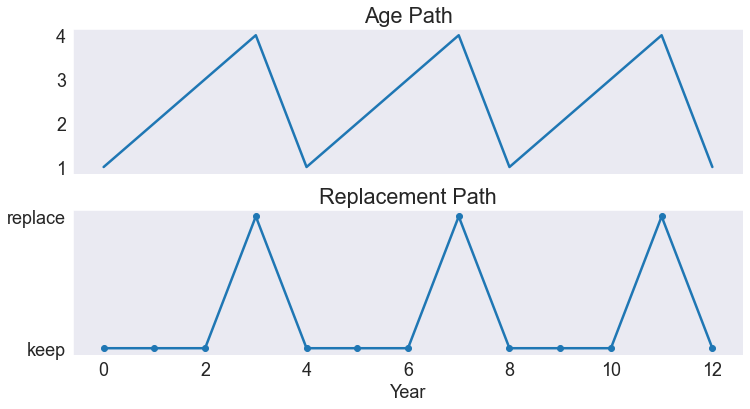

In [13]:
fig, axs = plt.subplots(2, 1, sharex=True)
simul['Age of Machine'].plot(ax=axs[0])
axs[0].set(title='Age Path');

simul['Action'].cat.codes.plot(marker='o', ax=axs[1])
axs[1].set(title='Replacement Path', yticks=[0, 1], yticklabels=X);